In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils        # for to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LearningRateScheduler   # callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import random
import math
import re   # для регулярных выражений 
import matplotlib.pyplot as plt
%matplotlib inline
 
from IPython.display import clear_output

 Предсказание цен товара

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Шиныдиски.csv', encoding= 'cp1251', sep=';', header=0) # Загружаем базу
print (df.shape) # Смотрим размер базы
df.head(3) # Смотрим что в ней есть

(48068, 4)


,Подкатегория 3,Имя товара,Цена,Производитель
0,Шины,Шины Yokohama Geolandar A/T G015 [Geolandar A/...,4741.0,Yokohama
1,Шины,Шины Yokohama Geolandar A/T G015 [Geolandar A/...,5432.9,Yokohama
2,Шины,Шины Yokohama Geolandar A/T G015 [Geolandar A/...,5401.0,Yokohama


In [ ]:
class EasyParser:

    def toСategory(self, val, dictionary):
      # Переводит val в категории по словарю dictionary            
      return utils.to_categorical(dictionary.index(val), len(dictionary))

    def signText(self, text):
      # Выбирает значимый текст
      st = text.replace(')',']').replace('(','[')  
      return st.split('[')[1].replace(']','')

    def MakeDict(self, df, column):
      # Возвращает список уникальных значений
      col =df[column].to_list()
      return  list(set(col)) 

xt = []
yt = []
xText = []
ep = EasyParser()

dictBrand = ep.MakeDict( df,'Производитель')
dictProduct =ep.MakeDict(df,'Подкатегория 3')
print(dictProduct)

for val in df.values:
  prod = ep.toСategory(val[0], dictProduct)     # Товар -> 01
  brand = ep.toСategory(val[3], dictBrand)      # Производитель -> 01
  x = np.hstack([prod, brand])
  xt.append(x)
  xText.append(ep.signText(val[1]))
  yt.append(val[2]/1000.)   # в т. руб

xT = np.array(xt)
yT = np.array(yt)

xText[10001]

['Грузовые шины', 'Мотошины', 'Диски', 'Шины']


'WR SUV 3 295/40 R20 110V'

In [ ]:
maxWordsCount = 8000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(xText) #  словарь частотности

items = list(tokenizer.word_index.items())

In [ ]:
print(len(items))   # Правильно ли выбран maxWordsCount

7347


In [ ]:
xWordIndexes = tokenizer.texts_to_sequences(xText)
#x01 = tokenizer.sequences_to_matrix(l) #П одаем xTrain в виде списка, чтобы метод успешно сработал
#xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал
print("В виде оригинального текста:        ", xText[1][:87])
print("В виде последовательности индексов: ", xWordIndexes[1][:20], '\n')

В виде оригинального текста:         Geolandar A/T G015 215/60 R16 95H
В виде последовательности индексов:  [213, 99, 72, 512, 27, 17, 10, 289] 



In [ ]:
xT01 = tokenizer.sequences_to_matrix(xWordIndexes) # Подаем  в виде списка, чтобы метод успешно сработал

In [ ]:
vmask = np.random.sample(xT.shape[0]) < 0.2 # маска True-False проверочной выборки

In [ ]:
def scheduler(epoch, lr):
  if epoch > 10 and epoch % 20 == 0:
    lr /= 10
  return lr 

callback = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
# Cеть
input1 = Input((xT.shape[1],))
input2 = Input((xT01.shape[1],))

xt = Dense(400, activation="relu")(input1)
xtxt = Dense(1000, activation="relu")(input2)

x = concatenate([xt, xtxt])

x = Dense(1000, activation='relu')(x)
x = Dense(300, activation='relu')(x)
x = Dense(1, activation='relu')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mae')
history = model.fit([xT[~vmask], xT01[~vmask]], yT[~vmask], 
                    epochs=90,  batch_size=100,
                    validation_data=([xT[vmask], xT01[vmask]], yT[vmask]), 
                    callbacks=[callback], verbose=1)


Epoch 1/90

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 50s 127ms/step - loss: 2.2490 - val_loss: 0.9979
Epoch 2/90

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 48s 126ms/step - loss: 0.8989 - val_loss: 1.0103
Epoch 3/90

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 48s 126ms/step - loss: 0.7617 - val_loss: 0.9636
Epoch 4/90

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 48s 125ms/step - loss: 0.6967 - val_loss: 0.7999
Epoch 5/90

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 48s 125ms/step - loss: 0.6003 - val_loss: 0.7580
Epoch 6/90

Epoch 00006: LearningRateScheduler reducing lear

Визуализация

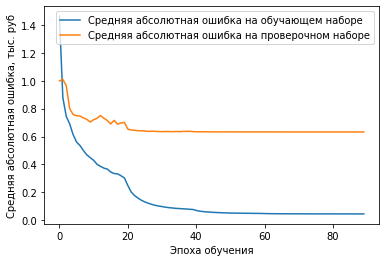

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка, тыс. руб')
plt.legend()
plt.show()

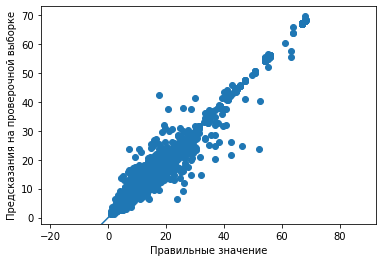

In [ ]:
y = yT[vmask]
pred = model.predict([xT[vmask], xT01[vmask]]) # Предсказанная цена на проверочной выборке
plt.scatter(y, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания на проверочной выборке')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-200, 200], [-200, 200])
plt.show()

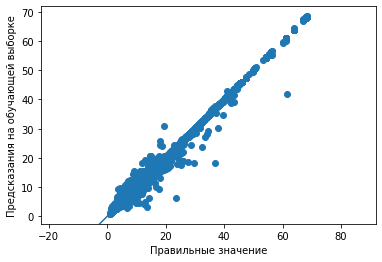

In [ ]:
# на обучающей выборке
y = yT[~vmask]
pred = model.predict([xT[~vmask], xT01[~vmask]]) # Предсказанная цена
plt.scatter(y, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания на обучающей выборке')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-5, 5], [-5, 5])
plt.show()

In [ ]:
Выводы:
1. В данном наборе информация о товаре, в большей мере, заложена в текстовую часть.
 На самом деле - это числовые и буквенные хакракткристики тежнических параметров.
 У разных производителей параметры могут различаться по содержанию и их анализ 
 довольно сложен и требует много времни. 
 В этом случае - предоставить нейронной сети "самой разобраться" - удачный вариант.
 Модель показала точность порядка 10% от цены товара, что, на мой взляд - хорошо.
2.Обучение на 90 эпохах - избыточно, и сделано скорей для того, чтобы убедиться в этом.
3. Разброс на обучающей выборке - меньше чем на проверочной,  наличие разброса
 говорит о том, что модель не "вызубрила правильные ответы"